<a href="https://colab.research.google.com/github/farmer-nusantara/farmer-nusantara-machine-learning/blob/master/Corn_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [24]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Import dependencies
from google.colab import files ## Upload file(s) from local
import zipfile ## Unzip zip file(s)
import os ## Interact with file system
import shutil ## Copy file(s)

## Plot image(s)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np ## Images array handle
import tensorflow as tf ## Deep learning library
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator ## Image preprocess and augmentation

import random ## Get random image(s)
import tempfile ## Generate temporary files and directories

# **Data Preparation**
[Corn Dataset](https://www.kaggle.com/datasets/soumiknafiul/plantvillage-dataset-labeled?select=PlantVillage+Dataset+%28Labeled%29)

The dataset is from kaggle "PlantVillage" for project purpose we modified the dataset, just only have "Corn/Maize" class.

Link for dataset in Google Drive
https://drive.google.com/file/d/1Z_3m27txFNG5uxVSalnbxJFy6kZc7FSa/view?usp=sharing

## **Google Drive Authentication**

In [3]:
!pip install -U -q PyDrive

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link = 'https://drive.google.com/file/d/1Z_3m27txFNG5uxVSalnbxJFy6kZc7FSa/view?usp=sharing'

In [7]:
id = link.split('d/')[1].split('/view?')[0]
print (id)

1Z_3m27txFNG5uxVSalnbxJFy6kZc7FSa


## **Download and Unzip Files**

In [8]:
drive_file = drive.CreateFile({'id':id})  
drive_file.GetContentFile('Plant-Village-Corn.zip')

In [9]:
file_zip = 'Plant-Village-Corn.zip'
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall('content/Plant-Village-Corn.zip')
zip_ref.close()

print(os.listdir('content/Plant-Village-Corn.zip'))

['Northern_Leaf_Blight', 'Cercospora_Leaf_Spot_Gray_Leaf_Spot', 'Healthy', 'Common_Rust']


# **Exploratory Data Analysis**

In [10]:
def move_image(src_dir, classname_list, destination_root_dir):
  """
  Params:
          src_dir: Root directory of source, enclosed by string
          classname_list : List contains desired name of class(es), ordered alphabetically
          destination_root_dir : Root directory of destination
  """ 
  if not os.path.exists(destination_root_dir):
    os.makedirs(destination_root_dir) 
  class_src = sorted([dirs for root, dirs, files in os.walk(src_dir)][0])
  for index in range(len(classname_list)):
    if os.path.exists(os.path.join(destination_root_dir, str(classname_list[index]))):
      os.makedirs(os.path.join(destination_root_dir, str(classname_list[index])))
    if len(class_src) == len(classname_list):
      shutil.copytree(os.path.join(src_dir, str(class_src[index])),
                      os.path.join(destination_root_dir, str(classname_list[index])))
    else:
      raise Exception("Number of directories not equal between source and destination")

In [11]:
cornleaf_classname = ['Cercospora_Leaf_Spot_Gray_Leaf_Spot', 
                      'Common_Rust',
                      'Healthy', 
                      'Northern_Leaf_Blight']

src_dir = ('content/Plant-Village-Corn.zip')
root_dir = '/tmp/Data'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

move_image(src_dir, cornleaf_classname, root_dir)

In [12]:
def simple_eda(data_dir):
  """
  Params:
              
  """ 
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  class_num = len(class_list)
  print("There are {} classes with various number of images for each".format(class_num))

  images_num = []
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    images_num.append(len(os.listdir(class_dir)))
    print("\n - {} : {} images".format(each_class, len(os.listdir(class_dir))))

  plt.figure(figsize=(8, 6))
  ax = plt.subplot()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  plt.bar(class_list, images_num, zorder=3)
  plt.grid(zorder=0)
  plt.title("Images Distribution", fontsize=20)
  plt.xlabel("Classes/Categories", fontsize=12)
  plt.show()

def display_sample(data_dir, num_sample):
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    plt.figure(figsize=(100/num_sample, 4))
    print("\nLabel: {}".format(each_class))
    for index, image_path in enumerate(os.listdir(class_dir)[:num_sample]):
        ax = plt.subplot(1, num_sample, index+1)
        image = mpimg.imread(os.path.join(class_dir, image_path))
        ax.grid()
        plt.imshow(image)
    plt.show()

There are 4 classes with various number of images for each

 - Cercospora_Leaf_Spot_Gray_Leaf_Spot : 513 images

 - Common_Rust : 1186 images

 - Healthy : 1162 images

 - Northern_Leaf_Blight : 978 images


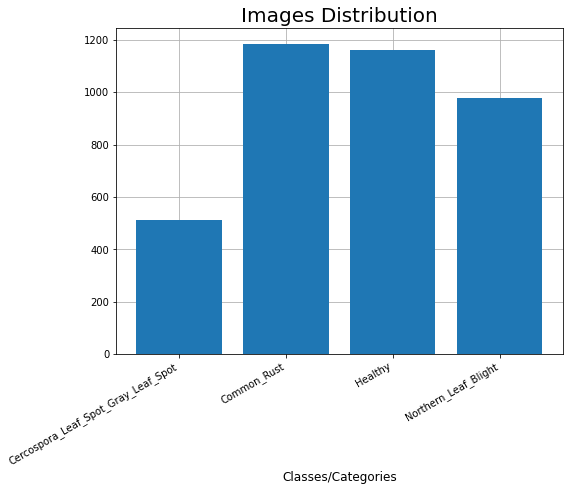

In [13]:
simple_eda(root_dir)


Label: Cercospora_Leaf_Spot_Gray_Leaf_Spot


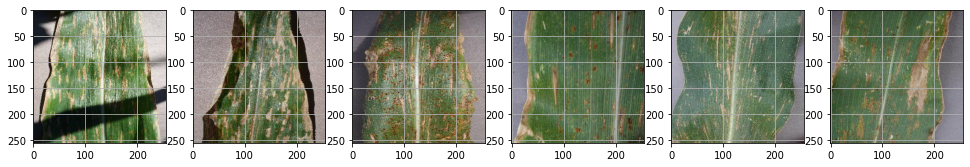


Label: Common_Rust


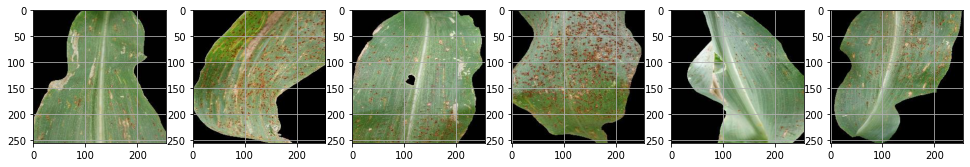


Label: Healthy


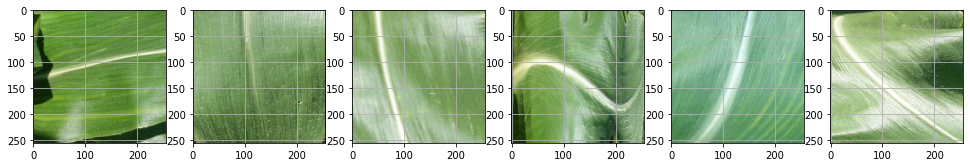


Label: Northern_Leaf_Blight


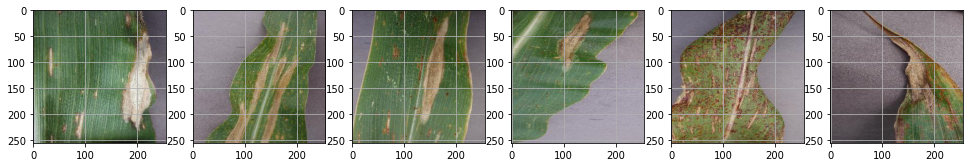

In [14]:
display_sample(root_dir, num_sample=6)

# **Split Dataset**

In [15]:
def split_class_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  """
  Params:
              
  """ 
  for dir in [TRAINING, VALIDATION, TESTING]:
    if not os.path.exists(dir):
      os.makedirs(dir)

  if SPLIT_SIZE > 1 or SPLIT_SIZE < 0:
    raise Exception('split size should be between 0 and 1')

  train_val_len = int(len(os.listdir(SOURCE)) * SPLIT_SIZE)
  for index, file in enumerate(os.listdir(SOURCE)): 
    if index < train_val_len:
      if index < int(.95 * train_val_len):
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TRAINING)))
      else:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(VALIDATION)))
    else:
      shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TESTING)))

def display_distribution(DIR, split_type=['Train', 'Validation', 'Test']):
  """
  Params:
                  
  """ 
  user_input_type = [split_type]
  type_list = ['Train', 'Validation', 'Test']
  if len(user_input_type) > 1:
    raise Exception("Please choose one type of split")
  if user_input_type[0] not in type_list:
    raise Exception("Please choose a type of split that provided; \'Train\', \'Validation\', or \'Test\'")
  
  print("\n{}".format(user_input_type[0]))
  for dir_class in sorted(os.listdir(DIR)):
    print('{}: {} images'.format(dir_class, len(os.listdir(os.path.join(DIR, dir_class)))))

In [16]:
root_split_dir = '/tmp/Split'

if os.path.exists(root_split_dir):
  shutil.rmtree(root_split_dir)

train_split_dir = os.path.join(root_split_dir, 'Train')
validation_split_dir = os.path.join(root_split_dir, 'Validation')
test_split_dir = os.path.join(root_split_dir, 'Test')

Cercospora_Leaf_Spot_Gray_Leaf_Spot_train_dir = os.path.join(train_split_dir, cornleaf_classname[0])
Common_Rust_train_dir = os.path.join(train_split_dir, cornleaf_classname[1])
Healthy_train_dir = os.path.join(train_split_dir, cornleaf_classname[2])
Northern_Leaf_Blight_train_dir = os.path.join(train_split_dir, cornleaf_classname[3])

Cercospora_Leaf_Spot_Gray_Leaf_Spot_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[0])
Common_Rust_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[1])
Healthy_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[2])
Northern_Leaf_Blight_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[3])

Cercospora_Leaf_Spot_Gray_Leaf_Spot_test_dir = os.path.join(test_split_dir, cornleaf_classname[0])
Common_Rust_test_dir = os.path.join(test_split_dir, cornleaf_classname[1])
Healthy_test_dir = os.path.join(test_split_dir, cornleaf_classname[2])
Northern_Leaf_Blight_test_dir = os.path.join(test_split_dir, cornleaf_classname[3])

Cercospora_Leaf_Spot_Gray_Leaf_Spot_source_dir = os.path.join(root_dir, cornleaf_classname[0])
Common_Rust_source_dir = os.path.join(root_dir, cornleaf_classname[1])
Healthy_source_dir = os.path.join(root_dir, cornleaf_classname[2])
Northern_Leaf_Blight_source_dir = os.path.join(root_dir, cornleaf_classname[3])

split_size = .999

split_class_data(Cercospora_Leaf_Spot_Gray_Leaf_Spot_source_dir, Cercospora_Leaf_Spot_Gray_Leaf_Spot_train_dir, Cercospora_Leaf_Spot_Gray_Leaf_Spot_validation_dir, Cercospora_Leaf_Spot_Gray_Leaf_Spot_test_dir, split_size)
split_class_data(Common_Rust_source_dir, Common_Rust_train_dir, Common_Rust_validation_dir, Common_Rust_test_dir, split_size)
split_class_data(Healthy_source_dir, Healthy_train_dir, Healthy_validation_dir, Healthy_test_dir, split_size)
split_class_data(Northern_Leaf_Blight_source_dir, Northern_Leaf_Blight_train_dir, Northern_Leaf_Blight_validation_dir, Northern_Leaf_Blight_test_dir, split_size)

print('[Split Distribution]')
display_distribution(train_split_dir, split_type='Train')
display_distribution(validation_split_dir, split_type='Validation')
display_distribution(test_split_dir, split_type='Test')

[Split Distribution]

Train
Cercospora_Leaf_Spot_Gray_Leaf_Spot: 486 images
Common_Rust: 1124 images
Healthy: 1102 images
Northern_Leaf_Blight: 928 images

Validation
Cercospora_Leaf_Spot_Gray_Leaf_Spot: 26 images
Common_Rust: 60 images
Healthy: 58 images
Northern_Leaf_Blight: 49 images

Test
Cercospora_Leaf_Spot_Gray_Leaf_Spot: 1 images
Common_Rust: 2 images
Healthy: 2 images
Northern_Leaf_Blight: 1 images


# **Data Generator and Augmented**

In [17]:
def display_augmentation(IMG_PATH, ROTATION_RANGE, WIDTH_SHIFT_RANGE, 
                         HEIGHT_SHIFT_RANGE, SHEAR_RANGE, ZOOM_RANGE):
  """
  Params:
          
  """ 
  image = load_img(IMG_PATH)
  image_array = img_to_array(image)
  image_exp = np.expand_dims(image_array, 0)

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=ROTATION_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_rotate = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=WIDTH_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_width_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     height_shift_range=HEIGHT_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_height_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     shear_range=SHEAR_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_shear = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=ZOOM_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_zoom = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_horizontal_flip = batch[0]

  fig = plt.figure(figsize=(10, 7))
  rows = 2
  cols = 4
  augmented_images = [0, image, image_rotate, image_width_shift, image_height_shift, image_shear, image_zoom, image_horizontal_flip]
  plt_title = [0, "Real Image", "Rotation", "Width Shift", "Height Shift", "Shear", "Zoom", "Horizontal Flip"]
  for index in range(len(augmented_images)):
    if index == 0:
      continue
    fig.add_subplot(rows, cols, index)
    plt.imshow(augmented_images[index])
    plt.axis('off')
    plt.title(plt_title[index])

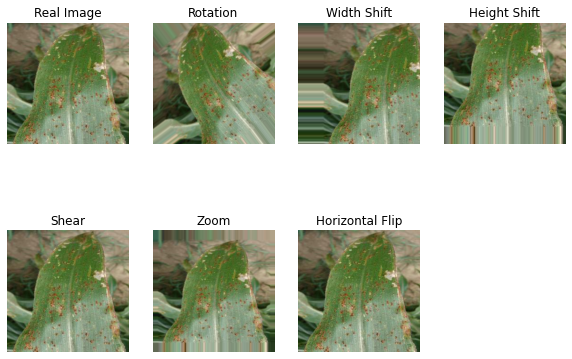

In [18]:
random_image = random.choice(os.listdir(Common_Rust_train_dir))
rotation_range = 40
width_shift_range = .3
height_shift_range = .3
shear_range = .4
zoom_range = .2
display_augmentation(os.path.join(Common_Rust_train_dir, random_image),
                     rotation_range,
                     width_shift_range,
                     height_shift_range,
                     shear_range,
                     zoom_range)

# **Model v1.1**

## **Model Architecture**

In [31]:
def train_val_generator(TRAINING_DIR, VALIDATION_DIR, 
                         TARGET_SIZE, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE):
  """
  Params:
        TRAINING_DIR: Directory for training split that contains classes directory
        VALIDATION_DIR: Directory for validation split that contains classes directory
        TARGET_SIZE: Tuple contains target size height and width
        TRAIN_BATCH_SIZE: Desired train split batch size
        VAL_BATCH_SIZE: Desired validation split batch size
  Returns:
        train_genetator: Image data generator for train split
        validation_generator: Image data generator for validation split
  """ 
  ## Instantiate the ImageDataGenerator class with images augmentation
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  ## Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=TRAIN_BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=TARGET_SIZE)

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=VAL_BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=TARGET_SIZE)
  return train_generator, validation_generator

In [32]:
# Set batch size and target image size
train_batch_size = 256
val_batch_size = 128
target_size = (150, 150)

# Get train and validation data generator
train_generator, validation_generator = train_val_generator(train_split_dir,
                                                            validation_split_dir,
                                                            target_size,
                                                            train_batch_size,
                                                            val_batch_size)

Found 3640 images belonging to 4 classes.
Found 193 images belonging to 4 classes.


In [33]:
print("Train Generator code for each class \n{}".format(train_generator.class_indices))
print("\n Validation Generator code for each class \n{}".format(validation_generator.class_indices))

Train Generator code for each class 
{'Cercospora_Leaf_Spot_Gray_Leaf_Spot': 0, 'Common_Rust': 1, 'Healthy': 2, 'Northern_Leaf_Blight': 3}

 Validation Generator code for each class 
{'Cercospora_Leaf_Spot_Gray_Leaf_Spot': 0, 'Common_Rust': 1, 'Healthy': 2, 'Northern_Leaf_Blight': 3}


In [34]:
def create_model(TARGET_SIZE):
  """
  Params:
        TARGET_SIZE: Tuple contains target size height and width   
  Returns:
        model: Created model
  """ 
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                             input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax', name="predict_class")
  ])

  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
  return model

In [35]:
modelv1d1 = create_model(target_size)

modelv1d1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

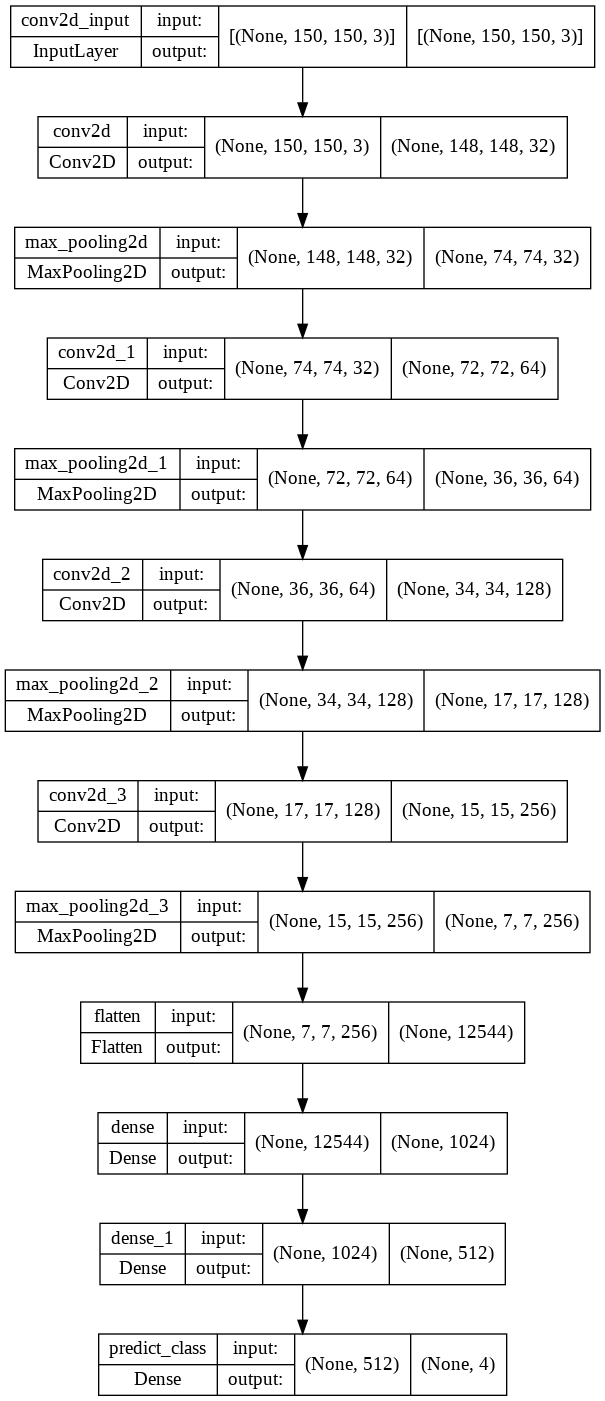

In [36]:
tf.keras.utils.plot_model(
    modelv1d1,
    to_file='modelv1d1.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)

## **Train the Model**

In [ ]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .95:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d1_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
# Train the model
history = modelv1d1.fit(train_generator,
                         epochs=50,
                         steps_per_epoch=int(train_generator.samples/train_batch_size),
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=int(validation_generator.samples/val_batch_size),
                         callbacks=[callbacks, early_stop, model_checkp])

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.1791 - accuracy: 0.4453 
Epoch 1: val_accuracy improved from -inf to 0.59375, saving model to model_v1d1_checkp.h5
14/14 [==============================] - 170s 12s/step - loss: 1.1791 - accuracy: 0.4453 - val_loss: 0.7935 - val_accuracy: 0.5938
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.6328 
Epoch 2: val_accuracy improved from 0.59375 to 0.63281, saving model to model_v1d1_checkp.h5
14/14 [==============================] - 172s 12s/step - loss: 0.7869 - accuracy: 0.6328 - val_loss: 0.8606 - val_accuracy: 0.6328
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.5990 
Epoch 3: val_accuracy improved from 0.63281 to 0.64062, saving model to model_v1d1_checkp.h5
14/14 [==============================] - 164s 12s/step - loss: 0.8206 - accuracy: 0.5990 - val_loss: 0.6498 - val_accuracy: 0.6406
Epoch 4/50
14/14 [============================

## **Result Plot**

In [ ]:
# Plot the train result
## Get accuracy and val_accuracy histories
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

## Get accuracy and val_accuracy losses
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.show() 

plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.show()  

NameError: ignored

## **Predict**

Actual class: Healthy
Predicted class: Healthy
 with the probabilities for each class as follow 
[0.01757265 0.00103212 0.975087   0.00630816]


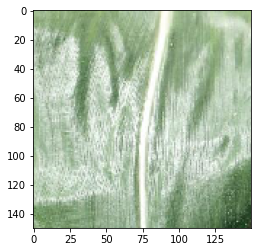

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(cornleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d1.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(cornleaf_classname[predicted_class], classes[0]))

Actual class: Cercospora_Leaf_Spot_Gray_Leaf_Spot
Predicted class: Cercospora_Leaf_Spot_Gray_Leaf_Spot
 with the probabilities for each class as follow 
[8.3761030e-01 3.7678730e-04 5.4165835e-06 1.6200751e-01]


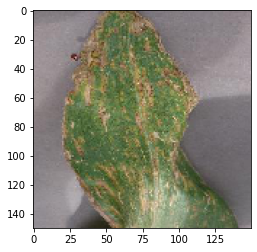

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(cornleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d1.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(cornleaf_classname[predicted_class], classes[0]))

## **Save & Export Model**

In [ ]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 1
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
modelv1d1.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './cornmodelv1d1.h5' 
modelv1d1.save(saved_h5_format)

INFO:tensorflow:Assets written to: /tmp/1/1/assets

export_path = /tmp/1/1
total 232
drwxr-xr-x 2 root root   4096 May 31 01:49 assets
-rw-r--r-- 1 root root  24962 May 31 01:49 keras_metadata.pb
-rw-r--r-- 1 root root 199041 May 31 01:49 saved_model.pb
drwxr-xr-x 2 root root   4096 May 31 01:49 variables


In [ ]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelv1d1.zip' {export_json_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Prepare the path, cleaning up!

updating: tmp/1/1/json_format/ (stored 0%)
updating: tmp/1/1/json_format/group1-shard3of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard12of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard11of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard8of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard2of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard10of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard13of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard1of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard4of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard6of14.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard7of14.bin (deflated 8%)
updating: tmp/1/1/json_format/model.json (deflated 85%)
updating: tmp/1/1/json_format/group1-sh

In [ ]:
# Convert to .tflite format
## Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

## Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

## Use the tool to finally convert the model
tflite_model = converter.convert()

## Write TFLite model and its classes
tflite_model_file = 'cornmodel_v1_d1.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)

with open('cornclasses_v1_d1.txt', 'w') as classes:
    classes.write('\n'.join(cornleaf_classname))

In [ ]:
try:
    files.download('cornmodel_v1_d1.tflite')
    files.download('cornclasses_v1_d1.txt')
    files.download('jsonmodelv1d1.zip')
    
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model v1.2 - Transfer Learning: InceptionV3**

## **Model Architecture**

In [28]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-02 03:19:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   188MB/s    in 0.4s    

2022-06-02 03:19:19 (188 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [29]:
# Get the pre-trained model
def create_pre_trained_model(WEIGHTS, TARGET_SIZE):
  """
  Params:
        WEIGHTS: Choosen weights from pre trained model
        TARGET_SIZE: Tuple contains target size height and width   
  Returns:
        pre_trained_model: Imported pre trained model
  """ 
  ## Import InceptionV3 Model
  pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
      input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3),
      include_top = False, 
      weights = None)

  pre_trained_model.load_weights(WEIGHTS)
  
  return pre_trained_model

In [37]:
# Execute create_pre_trained_model function
## Use downloaded weights
pre_trained_model = create_pre_trained_model('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                             target_size)

## Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_4[0][0]']               
 alization)                                                                                       
                                                                                       

In [38]:
# Create a function to pipeline imported model
## Set the desired layer from pre-trained model as a input for self-model
def output_of_last_layer(PRE_TRAINED_MODEL):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model  
  Returns:
        last_output: The desired layer as a input for self-model
  """ 
  last_desired_layer = PRE_TRAINED_MODEL.get_layer('mixed7')
  last_output = last_desired_layer.output

  return last_output

In [39]:
# Execute the prior function
last_output = output_of_last_layer(pre_trained_model)

In [40]:
# Create Final Model
def create_model(PRE_TRAINED_MODEL, LAST_OUTPUT):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model 
        LAST_OUTPUT: The desired layer as a input for self-model  
  Returns:
        model: Created model
  """ 
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(LAST_OUTPUT)
  # Add a fully connected layer with hidden units and ReLU activation
  x = tf.keras.layers.Dense(2048, activation='relu')(x)
  # Add a dropout rate
  x = tf.keras.layers.Dropout(.3)(x)
  # Add another hidden layer
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # Add another dropout rate
  #x = tf.keras.layers.Dropout(.3)(x)
  # Add another hidden layer
  #x = tf.keras.layers.Dense(256, activation='relu')(x)
  # Add a output layer for classification
  x = tf.keras.layers.Dense(4, activation='softmax', name="predict_class")(x) 

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=PRE_TRAINED_MODEL.input, outputs=x)

  # Fine Tuning
  NUM_LAYERS = 20 #@param {type:"slider", min:1, max:50, step:1}
  do_fine_tuning = True #@param {type:"boolean"}

  if do_fine_tuning:
      optimizer = tf.keras.optimizers.SGD(lr=5e-3, momentum=0.9)
    
      for layer in model.layers[-NUM_LAYERS:]:
          layer.trainable = True

      # Make all the layers in the pre-trained model trainable
      for layer in pre_trained_model.layers:
          layer.trainable = True
  else:
      optimizer = 'adam'

      # Make all the layers in the pre-trained model non-trainable
      for layer in pre_trained_model.layers:
          layer.trainable = False

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  return model

In [41]:
# Get the model architecture by pass target_size defined before
modelv1d2 = create_model(pre_trained_model, last_output)

# Get model summary
modelv1d2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_4[0][0]']               
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 batch_normalization_8 (BatchNo  (None, 16, 16, 64)  192         ['conv2d_12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 48)   9216        ['max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_13 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 16, 16, 48)  144         ['conv2d_10[0][0]']              
 rmalizati

In [43]:
# plot the model architecture
tf.keras.utils.plot_model(
    modelv1d2,
    to_file='modelv1d3.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)

## **Train the Model**

In [44]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .95:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d2_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [45]:
# Train the model
history = modelv1d2.fit(train_generator,
                         epochs=50,
                         steps_per_epoch=int(train_generator.samples/train_batch_size),
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=int(validation_generator.samples/val_batch_size),
                         callbacks=[callbacks, early_stop, model_checkp])

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.1293 - accuracy: 0.5824 
Epoch 1: val_accuracy improved from -inf to 0.66406, saving model to model_v1d2_checkp.h5
14/14 [==============================] - 651s 45s/step - loss: 1.1293 - accuracy: 0.5824 - val_loss: 0.7240 - val_accuracy: 0.6641
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8475 
Epoch 2: val_accuracy improved from 0.66406 to 0.85938, saving model to model_v1d2_checkp.h5
14/14 [==============================] - 633s 45s/step - loss: 0.4260 - accuracy: 0.8475 - val_loss: 0.3306 - val_accuracy: 0.8594
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9122 
Epoch 3: val_accuracy improved from 0.85938 to 0.91406, saving model to model_v1d2_checkp.h5
14/14 [==============================] - 639s 45s/step - loss: 0.2224 - accuracy: 0.9122 - val_loss: 0.2076 - val_accuracy: 0.9141
Epoch 4/50
14/14 [============================

## **Result Plot**

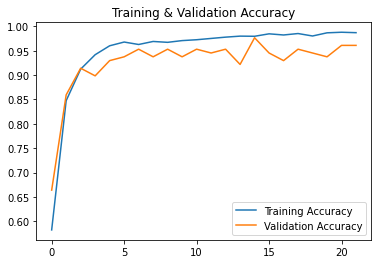

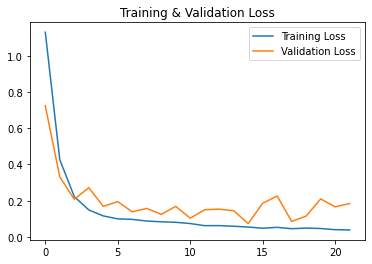

In [46]:
# Plot the train result
## Get accuracy and val_accuracy histories
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

## Get accuracy and val_accuracy losses
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.show() 

plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.show()  

## **Overall Accuracy Model**

In [48]:
train_score = modelv1d2.evaluate(train_generator)
validation_score = modelv1d2.evaluate(validation_generator)

print('Overall Train Accuracy : ', train_score[1])
print('Overall Validation Accuracy: ', validation_score[1])

2/2 [==============================] - 7s 2s/step - loss: 0.1418 - accuracy: 0.9637
Overall Train Accuracy :  0.9840659499168396
Overall Validation Accuracy:  0.9637305736541748


## **Image Predict**

Actual class: Northern_Leaf_Blight
Predicted class: Northern_Leaf_Blight
 with the probabilities for each class as follow 
[1.0818232e-01 8.3260040e-04 2.4856190e-06 8.9098257e-01]


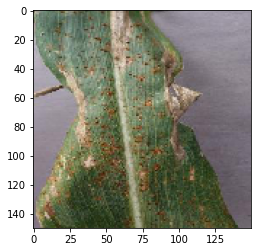

In [49]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(cornleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d2.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(cornleaf_classname[predicted_class], classes[0]))

Actual class: Common_Rust
Predicted class: Common_Rust
 with the probabilities for each class as follow 
[9.9346977e-08 9.9999988e-01 7.0193984e-10 3.8241815e-08]


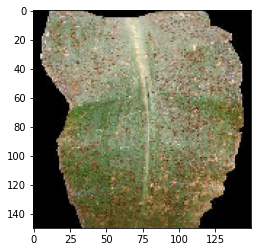

In [50]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(cornleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d2.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(cornleaf_classname[predicted_class], classes[0]))

## **Save & Export Model**

In [51]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 1
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
modelv1d2.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './cornmodelv1d2.h5' 
modelv1d2.save(saved_h5_format)

INFO:tensorflow:Assets written to: /tmp/1/1/assets

export_path = /tmp/1/1
total 4064
drwxr-xr-x 2 root root    4096 Jun  2 08:02 assets
-rw-r--r-- 1 root root  482456 Jun  2 08:02 keras_metadata.pb
-rw-r--r-- 1 root root 3667426 Jun  2 08:02 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun  2 08:02 variables


In [57]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelv1d2.zip' {export_json_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Prepare the path, cleaning up!

updating: tmp/1/1/json_format/ (stored 0%)
updating: tmp/1/1/json_format/group1-shard5of85.bin (deflated 7%)
updating: tmp/1/1/json_format/group1-shard81of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard83of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard85of85.bin (deflated 7%)
updating: tmp/1/1/json_format/group1-shard67of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard69of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard38of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard49of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard16of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard17of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard19of85.bin (deflated 8%)
updating: tmp/1/1/json_format/group1-shard84of85.bin (deflated 8%)
updating: tmp/1/1/json

In [53]:
# Convert to .tflite format
## Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

## Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

## Use the tool to finally convert the model
tflite_model = converter.convert()

## Write TFLite model and its classes
tflite_model_file = 'cornmodel_v1_d2.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)

with open('cornclasses_v1_d2.txt', 'w') as classes:
    classes.write('\n'.join(cornleaf_classname))

In [58]:
try:
    files.download('cornmodel_v1_d2.tflite')
    files.download('cornclasses_v1_d2.txt')
    files.download('jsonmodelv1d2.zip')
    
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>